In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
from kipet.library.TemplateBuilder import *
from kipet.library.PyomoSimulator import *
from kipet.library.ParameterEstimator import *
from kipet.library.VarianceEstimator import *
from kipet.library.data_tools import *
from kipet.library.FESimulator import *
from pyomo.opt import *
import pickle
import os
import six

### Parameter Estimation for a fed batch reaction
$A + B \rightarrow C$

Initial conditions in reactor: 
* Initial volume $V_0=1L$
* $c_{A0} = 2, c_{B0} = 0, c_{C0} = 0$ (mol/L).

A stream of $B$ with concentration $2 mol/L$ is charged into reactor at rate $0.1 L/min$ over 15min.

Data is simulated using reaction rate constant $k_1=0.1 min^{-1}$ with added noise

Governing equations are:
$$
\begin{eqnarray}
\frac{dc_A}{dt} &=& -\frac{c_Aqin_B}{V} - k_1c_Ac_B \\
\frac{dc_B}{dt} &=& \frac{(cin_B - c_B)qin_B}{V} - k_1c_Ac_B \\
\frac{dc_C}{dt} &=& -\frac{c_Cqin_B}{V} + k_1c_Ac_B \\
\frac{dV}{dt} &=& qin_B
\end{eqnarray}
$$

In [3]:
filename = '/home/paperspace/learn_kipet/my_data_sets/ABC_fedbatch.csv'
C_frame = read_file(filename)

read dir : /home/paperspace/learn_kipet/my_data_sets/ABC_fedbatch.csv


In [5]:
C_frame = C_frame[['A', 'B', 'C']]
C_frame

,A,B,C
0.000000,2.083423,0.000000,0.000000
0.006957,2.050325,0.001389,0.000001
0.125632,1.819311,0.024509,0.000306
0.556208,2.044662,0.099940,0.005443
1.495467,1.541831,0.228099,0.032088
3.140156,1.213143,0.376072,0.101885
5.778965,1.342635,0.514788,0.217732
10.109477,0.844124,0.649458,0.355846
15.010179,0.700708,0.753979,0.439982
16.201092,-0.063078,0.723019,0.470846


In [56]:
builder = TemplateBuilder()  
    
builder.add_mixture_component('A',2.0)
builder.add_mixture_component('B',0.0)
builder.add_mixture_component('C',0.0)
    
builder.add_parameter('k1', 10, bounds = (0, 1000))

builder.add_algebraic_variable('qin_B')
builder.add_complementary_state_variable('V', 1)
cin_B = 2

In [57]:
def rule_odes(m,t):
    exprs = dict()
    exprs['A'] = -m.Z[t,'A'] * m.Y[t,'qin_B']/m.X[t,'V']-m.P['k1']*m.Z[t,'A']*m.Z[t,'B']
    exprs['B'] = (cin_B*m.Y[t,'qin_B'] - m.Z[t,'B'] * m.Y[t,'qin_B'])/m.X[t,'V']- m.P['k1']*m.Z[t,'A']*m.Z[t,'B']
    exprs['C'] = -m.Z[t,'C'] * m.Y[t,'qin_B']/m.X[t,'V'] + m.P['k1']*m.Z[t,'A']*m.Z[t,'B']
    exprs['V'] = m.Y[t, 'qin_B']
    return exprs

builder.set_odes_rule(rule_odes)

In [58]:
builder.add_concentration_data(C_frame)

Warning! Since C-matrix contains negative values Kipet is assuming a derivative of C has been inputted


In [59]:
model = builder.create_pyomo_model(0, 60)

In [60]:
sigmas = {'A':1,'B':1,'C':1}
p_estimator = ParameterEstimator(model)

In [61]:
qinB_traj = pd.DataFrame({'time':[0, 15, 16], 'qin_B':[0.1, 0.1, 0]}).set_index('time')
qinB_traj

,qin_B
time,
0,0.1
15,0.1
16,0.0


In [62]:
inputs_sub = {}
inputs_sub['Y'] = ['qin_B']

In [63]:
p_estimator.apply_discretization('dae.collocation',nfe=60,ncp=3,scheme='LAGRANGE-RADAU')
p_estimator.fix_from_trajectory('Y', 'qin_B', qinB_traj) 

[(0.0, 0.1),
 (0.001079, 0.1),
 (0.004487, 0.1),
 (0.006957, 0.1),
 (0.025358, 0.1),
 (0.083496, 0.1),
 (0.125632, 0.1),
 (0.192393, 0.1),
 (0.403332, 0.1),
 (0.556208, 0.1),
 (0.701841, 0.1),
 (1.161982, 0.1),
 (1.495467, 0.1),
 (1.750478, 0.1),
 (2.556207, 0.1),
 (3.140156, 0.1),
 (3.344731, 0.1),
 (3.991105, 0.1),
 (4.459561, 0.1),
 (4.664136, 0.1),
 (5.310509, 0.1),
 (5.778965, 0.1),
 (5.946828, 0.1),
 (6.477205, 0.1),
 (6.861593, 0.1),
 (7.029456, 0.1),
 (7.559833, 0.1),
 (7.944221, 0.1),
 (8.112084, 0.1),
 (8.642461, 0.1),
 (9.026849, 0.1),
 (9.194712, 0.1),
 (9.725089, 0.1),
 (10.109477, 0.1),
 (10.299442, 0.1),
 (10.899653, 0.1),
 (11.334653, 0.1),
 (11.524618, 0.1),
 (12.124828, 0.1),
 (12.559828, 0.1),
 (12.749793, 0.1),
 (13.350004, 0.1),
 (13.785004, 0.1),
 (13.974969, 0.1),
 (14.575179, 0.1),
 (15.010179, 0.09898209999999992),
 (15.194831, 0.08051689999999995),
 (15.778257, 0.022174300000000008),
 (16.201092, 0.0),
 (16.350422, 0.0),
 (16.822244, 0.0),
 (17.164194, 0.0),
 

In [64]:
# Again we provide options for the solver, this time providing the scaling that we set above
options = dict()
#options['nlp_scaling_method'] = 'user-scaling'
options['linear_solver'] = 'ma27'
# finally we run the optimization
results_pyomo = p_estimator.run_opt('ipopt',
                                        variances=sigmas,
                                      tee=True,
                                   solver_opts = options)

Ipopt 3.12: linear_solver=ma27


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:     6124
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      543

Total number of variables............................:     1444
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1444
Total

In [65]:
# And display the results
print("The estimated parameters are:")
for k,v in six.iteritems(results_pyomo.P):
    print(k, v)

The estimated parameters are:
k1 10


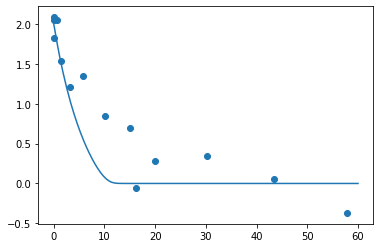

In [66]:
c = 'A'
fig, ax = plt.subplots()
ax.scatter(C_frame.index, C_frame[c])
ax.plot(results_pyomo.Z.index, results_pyomo.Z[c])

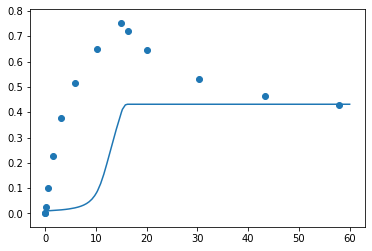

In [67]:
c = 'B'
fig, ax = plt.subplots()
ax.scatter(C_frame.index, C_frame[c])
ax.plot(results_pyomo.Z.index, results_pyomo.Z[c])

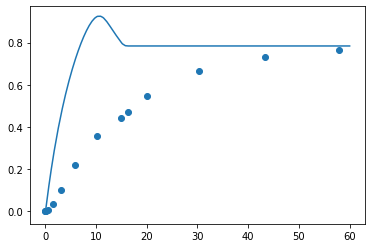

In [68]:
c = 'C'
fig, ax = plt.subplots()
ax.scatter(C_frame.index, C_frame[c])
ax.plot(results_pyomo.Z.index, results_pyomo.Z[c])